# MSc Mathematical and Computational Finance
Statistics and Financial Data Analysis - Problem Sheet 1
Jelmer Bennema - Oct 23 2023

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pylab
import datetime

## Data Analysis Report

### Download Data

In [2]:
# Download data 
Temp_data = pd.read_csv('SydTemp.csv')
Price_data = pd.read_csv('AEMOPriceDataSimple.csv')


# Test data 
test_x = Temp_data.loc[(Temp_data['Year'] == 2014.0) & (Temp_data['Month'] == 1.0) & (Temp_data['Day'] < 8.0)]

# select only data from 2013
Temp_data = Temp_data.loc[Temp_data['Year'] == 2013]

Temp_data.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C)
56248,IDCJAC0010,66062.0,2013.0,1.0,1.0,26.2,20.2
56249,IDCJAC0010,66062.0,2013.0,1.0,2.0,22.9,20.3
56250,IDCJAC0010,66062.0,2013.0,1.0,3.0,24.8,18.4
56251,IDCJAC0010,66062.0,2013.0,1.0,4.0,26.6,18.3
56252,IDCJAC0010,66062.0,2013.0,1.0,5.0,28.3,20.9


In [3]:
Price_data.head()

,Date,RRP
0,01/01/13,46.15
1,02/01/13,47.72
2,03/01/13,48.08
3,04/01/13,49.65
4,05/01/13,51.56


### Explore Data

In [4]:
# Drop outlier from both data sets (december 20th)
Price_data.drop(Price_data[Price_data['Date'] == '20/12/13'].index, inplace = True)

Temp_data.drop(Temp_data[(Temp_data['Month'] == 12.0) & (Temp_data['Day'] == 20.0)].index, inplace = True)

# realign indices 
Temp_data.reset_index(inplace = True)
Price_data.reset_index(inplace = True)

## add in day of the week
Temp_data['Day of Week'] = ''
temp = np.zeros(len(Temp_data))

for i in range(0, len(Temp_data)): 
    temp[i] = datetime.datetime(int(Temp_data.iloc[i]['Year']), int(Temp_data.iloc[i]['Month']), int(Temp_data.iloc[i]['Day'])).weekday()

Temp_data['Day of Week'] = temp

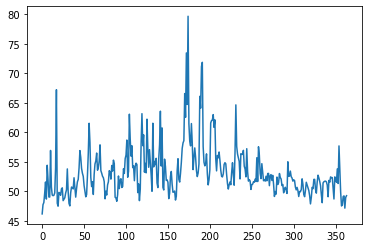

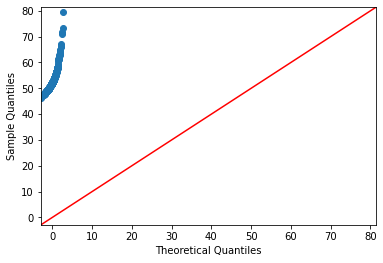

In [5]:
Price_data['RRP'].plot()

sm.qqplot(Price_data['RRP'], line='45')
pylab.show()

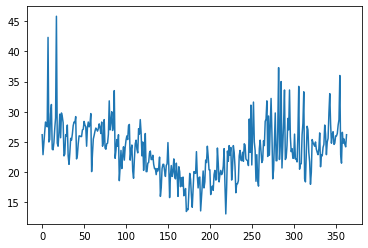

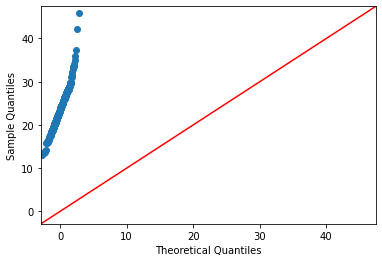

In [6]:
Temp_data['Maximum temperature (Degree C)'].plot()

sm.qqplot(Temp_data['Maximum temperature (Degree C)'], line='45')
pylab.show()

### generate different prediction models

#### Linear Regression Model

In [7]:
## Run linear Regression model
x = Temp_data[['Maximum temperature (Degree C)', 'Day of Week']]
y = Price_data['RRP']

# Fit and summarize OLS model
linear_regression = sm.OLS( y, sm.add_constant(x))

res = linear_regression.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    RRP   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     33.23
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           5.66e-14
Time:                        09:12:05   Log-Likelihood:                -1012.6
No. Observations:                 364   AIC:                             2031.
Df Residuals:                     361   BIC:                             2043.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Text(0.5, 1.0, 'Linear OLS Regression')

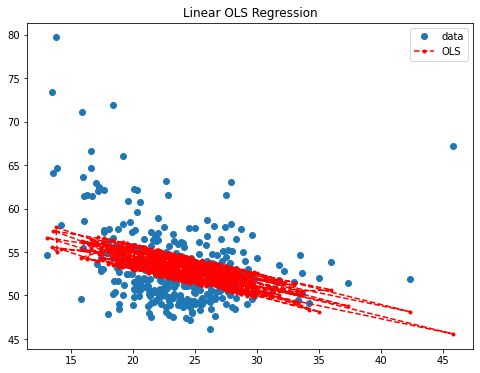

In [8]:
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(Temp_data['Maximum temperature (Degree C)'], y, "o", label="data")
ax.plot(Temp_data['Maximum temperature (Degree C)'], res.fittedvalues, "r--.", label="OLS")
#ax.plot(Temp_data['Maximum temperature (Degree C)'], iv_u, "r--")
#ax.plot(Temp_data['Maximum temperature (Degree C)'], iv_l, "r--")
ax.legend(loc="best")
plt.title('Linear OLS Regression')

#### Multivariate Polynomial Regression

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#specify degree of 3 for polynomial regression model
#include bias=False means don't force y-intercept to equal zero
poly = PolynomialFeatures(degree=3, include_bias=False)

#reshape data to work properly with sklearn
poly_features = poly.fit_transform(Temp_data['Maximum temperature (Degree C)'].to_numpy().reshape(-1, 1))
poly_features2 = poly.fit_transform(Temp_data['Day of Week'].to_numpy().reshape(-1, 1))

poly_features = np.concatenate((poly_features, poly_features2), axis = 1)

poly_features = sm.add_constant(poly_features)

# fit polynomial regression
model = sm.OLS(y, poly_features).fit()
ypred = model.predict(poly_features) 

ypred.shape
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    RRP   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     36.49
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           2.02e-34
Time:                        09:12:05   Log-Likelihood:                -956.35
No. Observations:                 364   AIC:                             1927.
Df Residuals:                     357   BIC:                             1954.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.6535      9.595     13.408      0.0

Text(0.5, 1.0, 'Polynomial Regression')

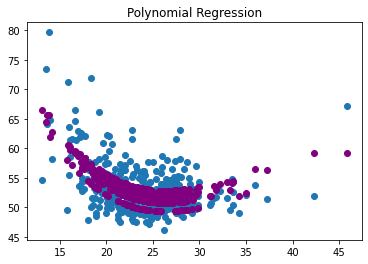

In [10]:
#use model to make predictions on response variable
y_predicted = model.predict(poly_features)

#create scatterplot of x vs. y
plt.scatter(Temp_data['Maximum temperature (Degree C)'], y)

#add line to show fitted polynomial regression model
plt.scatter(Temp_data['Maximum temperature (Degree C)'], y_predicted, color='purple')

plt.title('Polynomial Regression')

#### Orthonormal polynomial regression 
(to avoid multicolinearity factors)

In [11]:
def polyFit(x, degree = 3):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' does not correspond to number of points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    Z = np.delete(Z, 0, axis=1) #don't need constant, as will add to model
    return Z, norm2, alpha

In [12]:
Z, norm2, alpha = polyFit(Temp_data['Maximum temperature (Degree C)'],degree = 3);
p1 = Z[0:364,0]
p2 = Z[0:364,1]
p3 = Z[0:364,2]

# Check that polynomials are indeed orthonormal 
sum(p1 * p2)
sum(p1 * p3)
sum(p2 * p3)

3.8741254128338287e-16

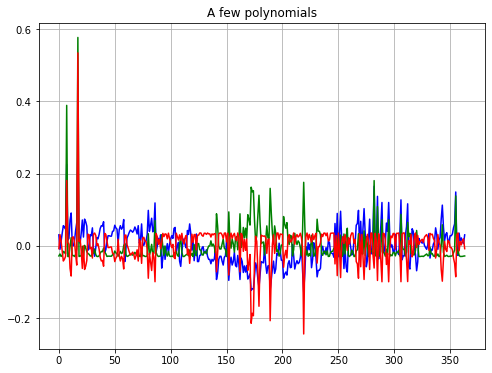

In [13]:
# Plotting the simple polynomials

plt.figure(1, figsize=(8,6))
plt.title('A few polynomials')
plt.plot(p1, 'b')
plt.plot(p2, 'g')
plt.plot(p3, 'r')
plt.grid()
plt.show()

In [17]:
ortho_polynomial = sm.OLS(y, sm.add_constant(Z)).fit()
ypred = ortho_polynomial.predict(sm.add_constant(Z)) 

ypred.shape
print(ortho_polynomial.summary())

                            OLS Regression Results                            
Dep. Variable:                    RRP   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     55.20
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           2.25e-29
Time:                        09:13:34   Log-Likelihood:                -974.52
No. Observations:                 364   AIC:                             1957.
Df Residuals:                     360   BIC:                             1973.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.2185      0.185    286.903      0.0

### Predict prices for first week of 2014

In [15]:
test_x = pd.DataFrame(columns = [['Max Temp', 'Day of Week']])
test_x['Max Temp'] = [27.1, 36.5, 26.2, 27.5, 26.0, 32.0, 21.6]
test_x['Day of Week'] = [2, 3, 4, 5, 6, 0, 1 ]

Text(0, 0.5, 'RRP Price')

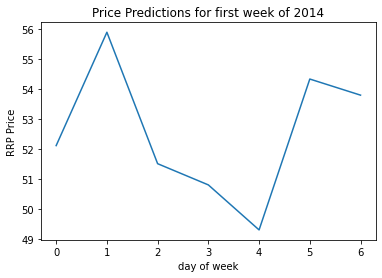

In [16]:
#reshape data to work properly with sklearn
poly_features = poly.fit_transform(test_x['Max Temp'].to_numpy().reshape(-1, 1))
poly_features2 = poly.fit_transform(test_x['Day of Week'].to_numpy().reshape(-1, 1))

poly_features = np.concatenate((poly_features, poly_features2), axis = 1)

poly_features = sm.add_constant(poly_features)


#reshape data to work properly with sklearn
#poly_features = poly.fit_transform(test_x['Max Temp'].to_numpy().reshape(-1, 1))
#poly_features = sm.add_constant(poly_features)

# predict values 
ypred = model.predict(poly_features) 

ypred.shape

plt.plot(ypred)
plt.title('Price Predictions for first week of 2014')
plt.xlabel('day of week')
plt.ylabel('RRP Price')

## Piecewise Polynomial Regression

In [49]:
# Define a piecewise polynomial function given data and knots, assume cubic splines

def pielinear(x, knots):
    n = len(knots) 
    ones = np.ones(len(x))
    res = np.vstack((ones, x, x**2, x**3))
    nullArray = np.zeros(len(x))
    
    for i in np.arange(0,n):
        res = np.vstack((res, np.maximum(x-knots[i],nullArray), 
                         np.maximum(x-knots[i],nullArray)**2, np.maximum(x-knots[i],nullArray)**3))
    return res

In [55]:
# Test my function, #1:

x = np.asarray([1,2,3,4,5,6,7,8])
knots = np.asarray([1.2,1.8])

y = pielinear(x,knots).T
np.set_printoptions(precision=1)
print(y)

[[  1.    1.    1.    1.    0.    0.    0.    0.    0.    0. ]
 [  1.    2.    4.    8.    0.8   0.6   0.5   0.2   0.    0. ]
 [  1.    3.    9.   27.    1.8   3.2   5.8   1.2   1.4   1.7]
 [  1.    4.   16.   64.    2.8   7.8  22.    2.2   4.8  10.6]
 [  1.    5.   25.  125.    3.8  14.4  54.9   3.2  10.2  32.8]
 [  1.    6.   36.  216.    4.8  23.  110.6   4.2  17.6  74.1]
 [  1.    7.   49.  343.    5.8  33.6 195.1   5.2  27.  140.6]
 [  1.    8.   64.  512.    6.8  46.2 314.4   6.2  38.4 238.3]]


In [57]:
# Test my function, #2:

x = np.asarray([1,2,3,2.5,5,10,100,2])
knots = np.asarray([1.5,2.0, 2.5, 3.0])

y = pielinear(x,knots).T
np.set_printoptions(precision=1)
print(y)

[[      1.        1.        1.        1.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0. ]
 [      1.        2.        4.        8.        0.5       0.2       0.1
        0.        0.        0.        0.        0.        0.        0.
        0.        0. ]
 [      1.        3.        9.       27.        1.5       2.2       3.4
        1.        1.        1.        0.5       0.2       0.1       0.
        0.        0. ]
 [      1.        2.5       6.2      15.6       1.        1.        1.
        0.5       0.2       0.1       0.        0.        0.        0.
        0.        0. ]
 [      1.        5.       25.      125.        3.5      12.2      42.9
        3.        9.       27.        2.5       6.2      15.6       2.
        4.        8. ]
 [      1.       10.      100.     1000.        8.5      72.2     614.1
        8.       64.      512.        7.5      56.2     421.9       7.
       49.      343. ]
 [    